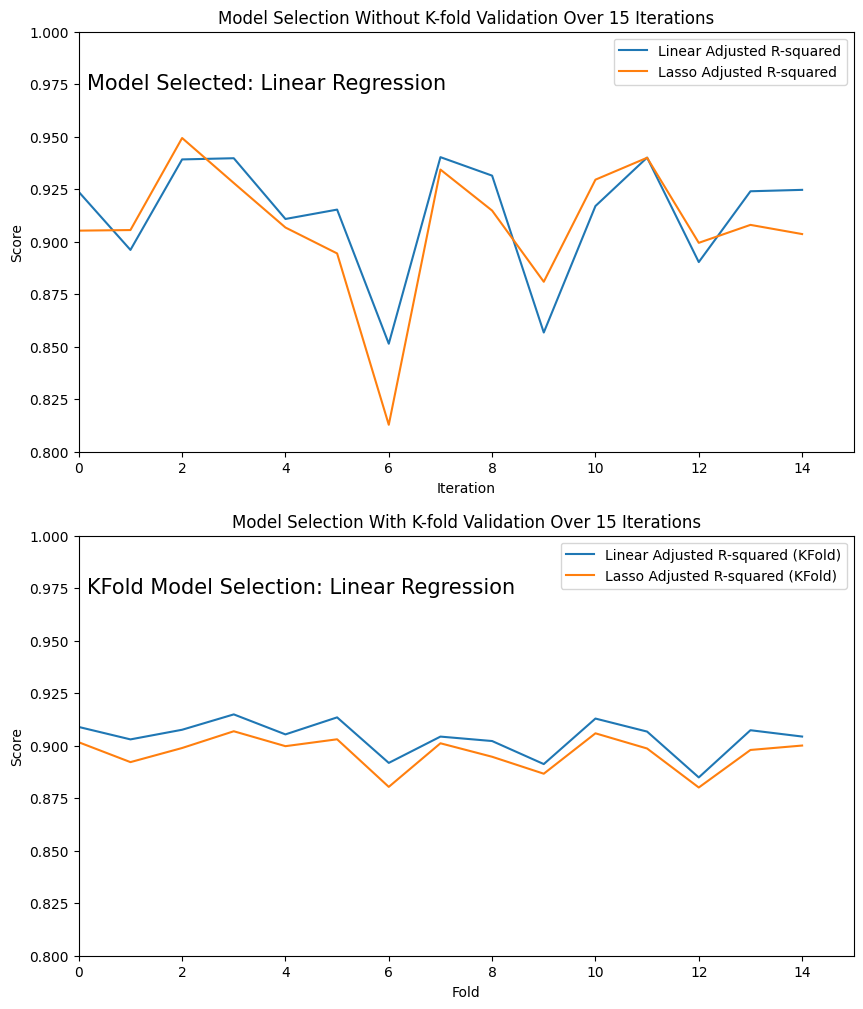

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
warnings.filterwarnings('ignore')

np.random.seed(0) # Use different seed for each iteration
X = np.random.uniform(0, 10, 100)
y = 2 + 0.6 * X**2 - 0.3 * X + np.random.normal(0, 4, len(X))

def adjusted_r2(r2, n, p):
  return 1 - (1 - r2) * ((n - 1)/(n-p-1))

linear_adj_r2_scores = []
lasso_adj_r2_scores = []
model_selection = []

for _ in range(15):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)

    poly = PolynomialFeatures(degree=5, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Linear Regression
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train_poly, y_train)
    y_pred_linear = linear_regressor.predict(X_test_poly)
    r2_linear = linear_regressor.score(X_test_poly, y_test)
    adj_r2_linear = adjusted_r2(r2_linear, len(y_test), X_test_poly.shape[1])
    linear_adj_r2_scores.append(adj_r2_linear)

    # Lasso
    lasso = Lasso(alpha=20)
    lasso.fit(X_train_poly, y_train)
    y_pred_lasso = lasso.predict(X_test_poly)
    r2_lasso = lasso.score(X_test_poly, y_test)
    adj_r2_lasso = adjusted_r2(r2_lasso, len(y_test), X_test_poly.shape[1])
    lasso_adj_r2_scores.append(adj_r2_lasso)

    # Model selection
    if linear_adj_r2_scores[_] > lasso_adj_r2_scores[_]:
      model_selection.append("Linear Regression")
    else:
      model_selection.append("Lasso Regression")


# Using K fold
avg_linear_adj_r2_scores = []
avg_lasso_adj_r2_scores = []
kf_model_selection = []

for _ in range(15):
  n_splits = 5
  kf = KFold(n_splits=n_splits, shuffle=True)
  linear_adj_r2_scoreskf = []
  lasso_adj_r2_scoreskf = []

  for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      X_train = X_train.reshape(-1,1)
      X_test = X_test.reshape(-1,1)

      poly = PolynomialFeatures(degree=5, include_bias=False)
      X_train_poly = poly.fit_transform(X_train)
      X_test_poly = poly.transform(X_test)

      # Linear Regression
      linear_regressor = LinearRegression()
      linear_regressor.fit(X_train_poly, y_train)
      r2_linear = linear_regressor.score(X_test_poly, y_test)
      adj_r2_linear = adjusted_r2(r2_linear, len(y_test), X_test_poly.shape[1])
      linear_adj_r2_scoreskf.append(adj_r2_linear)

      # Lasso
      lasso = Lasso(alpha=20)
      lasso.fit(X_train_poly, y_train)
      r2_lasso = lasso.score(X_test_poly, y_test)
      adj_r2_lasso = adjusted_r2(r2_lasso, len(y_test), X_test_poly.shape[1])
      lasso_adj_r2_scoreskf.append(adj_r2_lasso)
  avg_linear_adj_r2_scores.append(np.mean(linear_adj_r2_scoreskf))
  avg_lasso_adj_r2_scores.append(np.mean(lasso_adj_r2_scoreskf))

  # kfold Model selection
  if avg_linear_adj_r2_scores[_] > avg_lasso_adj_r2_scores[_]:
    kf_model_selection.append("Linear Regression")
  else:
    kf_model_selection.append("Lasso Regression")



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

x = range(15)
line1, = ax1.plot([], [], label='Linear Adjusted R-squared')
line2, = ax1.plot([], [], label='Lasso Adjusted R-squared')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Score')
ax1.set_title('Model Selection Without K-fold Validation Over 15 Iterations')
ax1.legend()
ax1.set_ylim(0.8, 1)
ax1.set_xlim(0, 15)
text_object1 = ax1.text(0.01, 0.90, '', transform=ax1.transAxes, fontsize=15, verticalalignment='top')

line3, = ax2.plot([], [], label='Linear Adjusted R-squared (KFold)')
line4, = ax2.plot([], [], label='Lasso Adjusted R-squared (KFold)')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Score')
ax2.set_title('Model Selection With K-fold Validation Over 15 Iterations')
ax2.legend()
ax2.set_ylim(0.8, 1)
ax2.set_xlim(0, 15)
text_object2 = ax2.text(0.01, 0.90, '', transform=ax2.transAxes, fontsize=15, verticalalignment='top')


def animate(i):
    line1.set_data(x[:i+1], linear_adj_r2_scores[:i+1])
    line2.set_data(x[:i+1], lasso_adj_r2_scores[:i+1])
    text_object1.set_text(f'Model Selected: {model_selection[i]}')

    line3.set_data(x[:i+1], avg_linear_adj_r2_scores[:i+1])
    line4.set_data(x[:i+1], avg_lasso_adj_r2_scores[:i+1])
    text_object2.set_text(f"KFold Model Selection: {kf_model_selection[i % n_splits]}")

    return line1, line2, text_object1, line3, line4, text_object2

ani = animation.FuncAnimation(fig, animate, frames=len(avg_linear_adj_r2_scores), interval=500, blit=True)
ani.save('animation.gif', writer='pillow') # Save the animation as a GIF
plt.show()